### STA-LSTM model - multiclass training - 1434 coordinates

#### Environment preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
print(f"Dane będą wczytywane z: {COLAB_ROOT}")

Mounted at /content/drive
Dane będą wczytywane z: /content/drive/MyDrive/PainRecognitionProject/


In [ ]:
import os

%cd /content

!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [ ]:
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

!git clone {REPO_URL}

%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 313, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 313 (delta 23), reused 27 (delta 14), pack-reused 277 (from 1)
Receiving objects: 100% (313/313), 11.57 MiB | 17.71 MiB/s, done.
Resolving deltas: 100% (147/147), done.
/content/automatic-pain-recognition


In [ ]:
!pip install -r requirements.txt

In [ ]:
import sys
import os

sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### STA-LSTM model - multiclass training

In [6]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from training_utils.preprocessed_dataset import PreprocessedDataset
from training_utils.train import Trainer
from training_utils.evaluate import Evaluator
from models.STA_LSTM import STA_LSTM

In [7]:
MAX_SEQUENCE_LENGTH = 46
NUM_FEATURES = 1434
NUM_CLASSES = 5
HIDDEN_SIZE = 128
NUM_LAYERS = 2
NUM_EPOCHS = 200
BATCH_SIZE = 16
LEARNING_RATE = 0.00005
DROPOUT_PROB = 0.3
WEIGHT_DECAY = 0.005
SCHEDULER_FACTOR = 0.9

#### Data preparation

In [8]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/BioVid_HeatPain_processed_478_xyz_frontalized/')
MODEL_SAVE_DIR = os.path.join(COLAB_ROOT, 'models/')
LOCAL_PROCESSED_DATA_ROOT = '/content/temp_data/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
print("Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...")
if os.path.exists(LOCAL_PROCESSED_DATA_ROOT):
    shutil.rmtree(LOCAL_PROCESSED_DATA_ROOT)
try:
    shutil.copytree(PROCESSED_DATA_DIR, LOCAL_PROCESSED_DATA_ROOT)
    print("Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)")
    CURRENT_DATA_DIR = LOCAL_PROCESSED_DATA_ROOT

except Exception as e:
    print(f"Błąd kopiowania danych (sprawdź, czy dane są zamontowane): {e}")
    print("Używam danych bezpośrednio z Drive (może się zawiesić).")
    CURRENT_DATA_DIR = PROCESSED_DATA_DIR

In [11]:
train_dataset = PreprocessedDataset(
    'train',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=None,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=None,
    label_map=None,
)

val_dataset = PreprocessedDataset(
    'val',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=None,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=None,
    label_map=None,
)

test_dataset = PreprocessedDataset(
    'test',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=None,
    compute_euclidean=False,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=None,
    label_map=None,
)

In [12]:
def preview_single(dataset, idx=0, timesteps_to_show=3, features_to_show=8):
    x, y = dataset[idx]
    print(f"\nSingle sample idx={idx} from split={dataset.dataset_name}")
    print(f"x shape: {tuple(x.shape)}, y: {y}")
    print(np.round(x[:timesteps_to_show, :features_to_show], 4))

preview_single(train_dataset, 0)
preview_single(val_dataset, 0)
preview_single(test_dataset, 0)


Single sample idx=0 from split=train
x shape: (46, 1434), y: 0
tensor([[ 0.0166,  0.1003,  0.0049,  0.0033, -0.0350, -0.0782,  0.0000,  0.0000],
        [ 0.0074,  0.0975,  0.0028,  0.0024, -0.0366, -0.0783,  0.0000,  0.0000],
        [ 0.0077,  0.0955,  0.0037,  0.0022, -0.0362, -0.0781,  0.0000,  0.0000]])

Single sample idx=0 from split=val
x shape: (46, 1434), y: 0
tensor([[ 0.0002,  0.1079,  0.0064,  0.0040, -0.0341, -0.0773,  0.0000,  0.0000],
        [-0.0022,  0.1043,  0.0072,  0.0032, -0.0341, -0.0777,  0.0000,  0.0000],
        [-0.0005,  0.1048,  0.0073,  0.0031, -0.0340, -0.0774,  0.0000,  0.0000]])

Single sample idx=0 from split=test
x shape: (46, 1434), y: 0
tensor([[ 0.0002,  0.0989,  0.0039,  0.0052, -0.0319, -0.0745,  0.0000,  0.0000],
        [-0.0045,  0.0965,  0.0040,  0.0047, -0.0339, -0.0747,  0.0000,  0.0000],
        [-0.0028,  0.0980,  0.0043,  0.0052, -0.0344, -0.0745,  0.0000,  0.0000]])


In [13]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in train_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in val_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in test_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

torch.Size([16, 46, 1434]) torch.Size([16])
torch.Size([16, 46, 1434]) torch.Size([16])
torch.Size([16, 46, 1434]) torch.Size([16])


#### Model preparation

In [14]:
model = STA_LSTM(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_PROB).to(DEVICE)

#### Training

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=SCHEDULER_FACTOR,
    patience=10,
    min_lr=1e-7
)

model_name = 'testing_new_code_sta_lstm_5_classes_1434_coord.pt'
model_filepath = os.path.join(MODEL_SAVE_DIR, model_name)

In [17]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=DEVICE,
    model_save_path=model_filepath,
    num_epochs=NUM_EPOCHS,
    monitor='val_acc',  # or 'val_loss'
    minimize_monitor=False,
    save_best_only=True
)

In [ ]:
trainer.print_training_config()


In [19]:
final_model_path, best_model_path, history = trainer.fit()
print(f"Final model saved to: {final_model_path}")
if best_model_path:
    print(f"Best model saved to: {best_model_path}")


Starting training for 200 epochs on cuda
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_sta_lstm_5_classes_1434_coord.pt (metric=0.2000)
Epoch 1/200 | Time 22.00s | Train loss 1.6642 | Train acc 0.2020 | Val loss 1.6345 | Val acc 0.2000
Epoch 2/200 | Time 9.45s | Train loss 1.6485 | Train acc 0.1970 | Val loss 1.6110 | Val acc 0.2000
Epoch 3/200 | Time 7.03s | Train loss 1.6374 | Train acc 0.2070 | Val loss 1.6256 | Val acc 0.2000
Epoch 4/200 | Time 6.58s | Train loss 1.6315 | Train acc 0.2108 | Val loss 1.6115 | Val acc 0.2000
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_sta_lstm_5_classes_1434_coord.pt (metric=0.2008)
Epoch 5/200 | Time 7.12s | Train loss 1.6272 | Train acc 0.2034 | Val loss 1.6096 | Val acc 0.2008
Epoch 6/200 | Time 6.84s | Train loss 1.6274 | Train acc 0.1977 | Val loss 1.6136 | Val acc 0.2000
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/bes

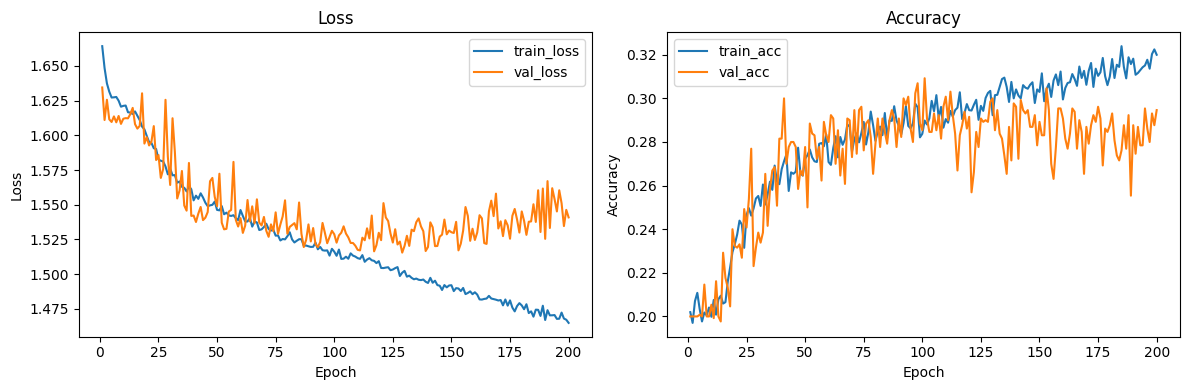

In [20]:
trainer.plot_history()

#### Evaluate

In [21]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE), strict=False)

<All keys matched successfully>

In [22]:
evaluator = Evaluator(model, test_loader, device=DEVICE, model_name=model_name, num_classes=NUM_CLASSES)


In [23]:
loss, acc, labels, preds = evaluator.evaluate_epoch()


WYNIKI OCENY DLA MODELU: testing_new_code_sta_lstm_5_classes_1434_coord.pt
Test Loss: 1.6300
Test Accuracy: 0.2885

--- Szczegółowy Raport Klasyfikacji ---
              precision    recall  f1-score   support

     Klasa 0       0.27      0.52      0.35       260
     Klasa 1       0.32      0.03      0.06       260
     Klasa 2       0.25      0.17      0.20       260
     Klasa 3       0.18      0.12      0.15       260
     Klasa 4       0.38      0.59      0.46       260

    accuracy                           0.29      1300
   macro avg       0.28      0.29      0.25      1300
weighted avg       0.28      0.29      0.25      1300

Confusion matrix:
 [[136   5  45  35  39]
 [129   9  40  33  49]
 [102   4  45  45  64]
 [ 91   5  29  32 103]
 [ 50   5  21  31 153]]
